In [1]:
import numpy as np
import os
from pybufrkit.decoder import generate_bufr_message
from pybufrkit.decoder import Decoder
from pybufrkit.dataquery import NodePathParser, DataQuerent


# Get a list of files with a similar name in a directory
path = '/Users/amfox/Downloads'
file_name = 'M02-ASCA-ASCSMO02-NA'
file_ext = '.bfr'
files = [file for file in os.listdir(path) if file.startswith(file_name) and file.endswith(file_ext)]

i = 1
lat = []
lon = []
ssom = [] # Surface soil moisture
tpcx = [] # Topographic complexity
domo = [] # Direction of motion of moving observing platform
smpf = [] # Soil moisture processing flag
smcf = [] # Soil moisture correction flag
alfr = [] # ASCAT land fraction
iwfr = [] # Inundation And Wetland Fraction % 0-40-009
snoc = [] # snow cover % 0-20-065
flsf = [] # frozen land fraction %  0-40-008

decoder = Decoder()

# Open each file in turn
for file in files:
    with open(os.path.join(path, file), 'rb') as fr:
        print ('Reading file ', file, '...')
# Loop for all messages
        for bufr_message in generate_bufr_message(decoder, fr.read()):
            #print ('Reading message number', i, '...')
            lat = np.append(lat, DataQuerent(NodePathParser()).query(bufr_message, '005001').all_values())
            lon = np.append(lon, DataQuerent(NodePathParser()).query(bufr_message, '006001').all_values())
            ssom = np.append(ssom, DataQuerent(NodePathParser()).query(bufr_message, '040001').all_values())
            # For QC-ing
            tpcx = np.append(tpcx, DataQuerent(NodePathParser()).query(bufr_message, '040010').all_values())
            domo = np.append(domo, DataQuerent(NodePathParser()).query(bufr_message, '001012').all_values())
            smpf = np.append(smpf, DataQuerent(NodePathParser()).query(bufr_message, '040006').all_values())
            smcf = np.append(smcf, DataQuerent(NodePathParser()).query(bufr_message, '040005').all_values())
            alfr = np.append(alfr, DataQuerent(NodePathParser()).query(bufr_message, '021166').all_values())
            iwfr = np.append(iwfr, DataQuerent(NodePathParser()).query(bufr_message, '040009').all_values())
            snoc = np.append(snoc, DataQuerent(NodePathParser()).query(bufr_message, '020065').all_values())
            flsf = np.append(flsf, DataQuerent(NodePathParser()).query(bufr_message, '040008').all_values())
            i = i + 1
    fr.close

Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701070300.000000000Z-20190701084345-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701052100.000000000Z-20190701070242-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701152700.000000000Z-20190701170548-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701120600.000000000Z-20190701134534-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701015700.000000000Z-20190701033848-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701134500.000000000Z-20190701152443-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701170600.000000000Z-20190701184615-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701033900.000000000Z-20190701052045-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701084500.000000000Z-20190701102507-1350206.bfr ...
Reading file  M02-ASCA-ASCSMO02-NA-5.0-20190701102700.000000000Z-20190701120550-1350206.bfr ...


In [2]:
numobs = len(ssom)
numobs

679392

In [3]:
numobs = len(ssom)

obs_array = np.empty([numobs, 11])

obs_array[:, 0] = ssom
obs_array[:, 1] = lon
obs_array[:, 2] = lat
obs_array[:, 3] = domo
obs_array[:, 4] = smpf
obs_array[:, 5] = smcf
obs_array[:, 6] = np.zeros(numobs)     # alfr There seems to be 3x these
obs_array[:, 7] = tpcx
obs_array[:, 8] = iwfr
obs_array[:, 9] = snoc
obs_array[:, 10] = flsf

In [23]:

is_nan = np.isnan(obs_array[:,4])
flag = np.unique(smpf[~is_nan])
flag

array([0, 1, 2, 4, 8, 16, 17, 18, 20, 24, 26, 32, 33, 34, 36, 40, 42, 48,
       50, 52, 56, 58, 64, 66, 68, 80, 82, 84, 88, 90, 96, 98, 104, 106,
       112, 114, 120, 122, 128, 130, 144, 146, 152, 154, 160, 162, 168,
       170, 176, 178, 184, 186], dtype=object)

In [72]:
x = 186
result = np.binary_repr(x, width=16)
print(result)

binary_num = "0000000010111010"
base10_num = int(binary_num, 2)
print(base10_num)

0000000010111010
186


In [37]:
obs_array[(obs_array[:,0] < 100.1) & (obs_array[:,4] == 0) & (obs_array[:,5] == 0), 6] = 1


In [38]:
qc_set = obs_array[obs_array[:,0] < 100.1]
qc1 = len(qc_set)
qc1

186047

In [39]:

qc_set = qc_set[qc_set[:,4] == 0]
qc2 = len(qc_set)
qc2

71469

In [40]:
qc_set = qc_set[qc_set[:,5] == 0]
qc3 = len(qc_set)
qc3

30732

In [41]:
#information for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

metric = 'ObsValue' # 'ObsValue'
colmin = None
colmax = None
units = None

In [42]:
# Make obarray
    
numobs = len(ssom)

obarray = np.empty([numobs, 3])

if metric == 'ObsValue':
    obarray[:, 0] = ssom
if metric == 'ombg':
    obarray[:, 0] = ssom - ssom

obarray[:, 1] = lon
obarray[:, 2] = lat

obarray[np.isnan(obarray)] = 120

#obarray[:, 0] = alfr[::3]


 Saving figure as Metop_A_07012019_qc3_histogram_qc3_obs.png 



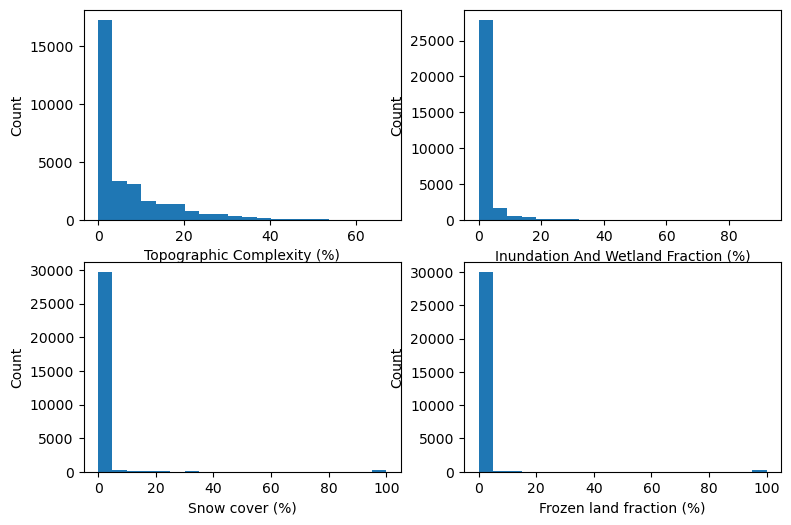

In [43]:
fig = plt.gcf()
fig.set_size_inches(9,6)

# TPCX
plt.subplot(2,2,1)
data = qc_set[:,7]
plt.hist(data,20)
plt.xlabel("Topographic Complexity (%)") 
plt.ylabel('Count')

# iwfr
plt.subplot(2,2,2)
data = qc_set[:,8]
plt.hist(data,20)
plt.xlabel("Inundation And Wetland Fraction (%)") 
plt.ylabel('Count')

# snoc
plt.subplot(2,2,3)
data = qc_set[:,9]
plt.hist(data,20)
plt.xlabel("Snow cover (%)") 
plt.ylabel('Count')

# flsf
plt.subplot(2,2,4)
data = qc_set[:,10]
plt.hist(data,20)
plt.xlabel("Frozen land fraction (%)") 
plt.ylabel('Count')

pname = "Metop_A_07012019_qc3"

savename = pname+"_histogram_qc3_obs.png"
print(" Saving figure as", savename, "\n")
plt.savefig(savename, dpi = 400)
plt.show()

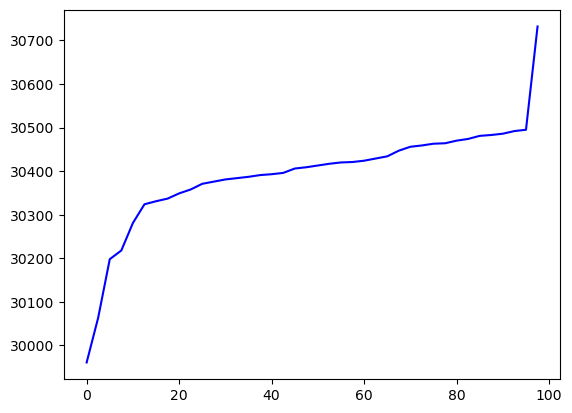

In [44]:
# evaluate the histogram
values, base = np.histogram(data, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

plt.show()

In [45]:


# Compute and print some stats for the data
# -----------------------------------------
stdev = np.nanstd(obarray[:,0])  # Standard deviation
omean = np.nanmean(obarray[:, 0]) # Mean of the data
datmi = np.nanmin(obarray[:, 0])  # Min of the data
datma = np.nanmax(obarray[:, 0])  # Max of the data

print("Plotted data statistics: ")
print("Mean: ", omean)
print("Standard deviation: ", stdev)
print("Minimum ", datmi)
print("Maximum: ", datma)


Plotted data statistics: 
Mean:  101.19942845956386
Standard deviation:  34.832935538463516
Minimum  0.0
Maximum:  120.0


In [46]:

# Norm for scatter plot
# ---------------------
norm = None


# Min max for colorbar
# --------------------
if np.nanmin(obarray[:, 0]) < 0:
    cmax = datma
    cmin = datmi
    cmap = 'RdBu'
else:
    cmax = omean+stdev
    cmin = np.maximum(omean-stdev, 0.0)
    cmap = 'viridis'

if metric == 'ObsValue':
    cmin = datmi
    cmax = datma

if metric == 'PreQC' or metric == 'EffectiveQC':
    cmin = datmi
    cmax = datma

# Specialized colorbar for integers
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[1] = (.5, .5, .5, 1.0)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.insert(np.linspace(0.5, int(cmax)+0.5, int(cmax)+1), 0, 0)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# If using omb then use standard deviation for the cmin/cmax
if metric=='omb' or metric=='ombg' or metric=='oman':
    cmax = stdev
    cmin = -stdev

# Override with user chosen limits
if (colmin!=None):
    print("Using user provided minimum for colorbar")
    cmin = colmin
if (colmax!=None):
    print("Using user provided maximum for colorbar")
    cmax = colmax

 Saving figure as Metop_A_07012019_qc5_ObsValue.png 



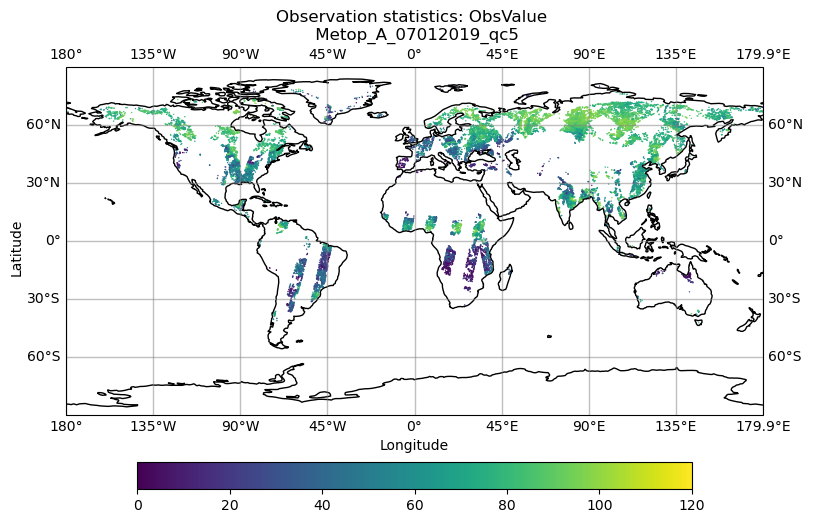

In [55]:
obarray[obarray[:,0]==120,0] = np.nan
obarray[(obs_array[:,4]!=0),0] = np.nan
obarray[(obs_array[:,5]!=0),0] = np.nan
obarray[(obs_array[:,7]>10),0] = np.nan
obarray[(obs_array[:,8]>10),0] = np.nan

# Create figure
# -------------

fig = plt.gcf()
fig.set_size_inches(9,6)

# initialize the plot pointing to the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# plot grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-180, -135, -90, -45, 0, 45, 90, 135, 179.9])
ax.set_ylabel("Latitude",  fontsize=7)
ax.set_xlabel("Longitude", fontsize=7)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# scatter data
sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=1, linewidth=0,
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=cmin, vmax=cmax, norm=norm)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel(units, fontsize=10)

# plot globally
ax.set_global()

# draw coastlines
ax.coastlines()

# figure labels

pname = "Metop_A_07012019_qc5"

plt.title("Observation statistics: "+metric+" \n "+
          pname) #, y=1.08)
ax.text(0.45, -0.1,   'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.08, 0.4, 'Latitude', transform=ax.transAxes, rotation='vertical', va='bottom')

savename = pname+'_'+metric+'.png'

print(" Saving figure as", savename, "\n")
plt.savefig(savename, dpi = 400)

In [56]:
print(np.count_nonzero(~np.isnan(obarray[:,0])))

22668


 Saving figure as percent_number_obs.png 



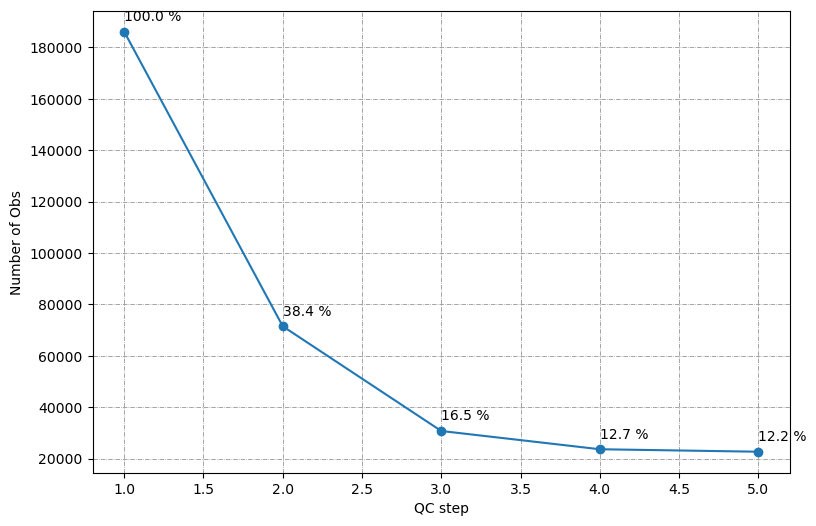

In [100]:
y = np.array([186047, 71469, 30732, 23634, 22668])
yy = np.round((y/186047)*100,1)
x = [1,2,3,4,5]

fig = plt.gcf()
fig.set_size_inches(9,6)

plt.plot(x, y,marker='o')
plt.ylabel("Number of Obs")
plt.xlabel("QC step")

# Add labels to markers
for i, j in zip(x, y):
    plt.annotate(f'{yy[i-1]} %', (i, j), textcoords="offset points", xytext=(0,8), ha='left')

plt.grid(color='gray', linestyle='-.', linewidth=0.5)


savename = "percent_number_obs.png"
print(" Saving figure as", savename, "\n")
#plt.savefig(savename, dpi = 400)

# Show the plot
plt.show()
